 **(originally part of a group project)**

$$\vec{B}(\vec{r}) =  \frac{\mu_0 I}{4 \pi} \int_C \frac{d\vec{l} \times (\vec{r}-\vec{l})}{|\vec{r}-\vec{l}|^3}$$

The following code is an approach to solving Biot-Savart's equation using Python with the help of Sympy and Numpy, mainly. Originally part of a computational assignment for Physics II at the *Universidad Nacional del Sur* (Argentina).

For a bit of context, this equation is used for solving the magnetic field produced by a current. In this solution, currents are linear and defined by a parameterized line.

A big inspiration for this approach was *Mr. P. Solver*'s video [*Biot Savart Law in Python: Any wire you want, no paper required*](https://www.youtube.com/watch?v=srk2YZKMn-E&t=538s). Most of this code was based on his solution.

However, we introduced some changes:  
  - Working with a *set* of parameterized lines.
  - The parameterized lines are defined *only once*. From this single definition the magnetic field is calculated and then graphed.


In [21]:
# Dependencies necessary for solving Biot-Savart's equation
import numpy as np
import sympy as smp
from sympy.vector import cross
from scipy.integrate import quad, quad_vec

In [22]:
# Dependencies necessary for graphing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.io as pio
pio.renderers.default = 'colab'
from IPython.display import HTML

**Defining the parameterized lines**

We first need to define the parameter $t$ for the parameterized lines

In [23]:
t = smp.symbols('t')

We now proceed to define a list $l$ of parameterized lines and a list $I$ of current values. The current at position $i$, say $I[i]$, corresponds to the parameterized line $l[i]$  
  
*yes, this could be done better, maybe by attaching the current value in the structure of the list of parameterized lines*

In [24]:
# Here we define a list l of parameterized lines, each is a vector containing the definition for each line
l = [smp.Matrix([smp.cos(2*np.pi*t), smp.sin(2*np.pi*t), 0.5]),
     smp.Matrix([smp.cos(2*np.pi*t), smp.sin(2*np.pi*t), -0.5])]

# We also define a current list, with each position indicating the value of the current at that position in the list of lines
I = [6, 6]

For example, we can see how the first parameterized line looks like

(with *6.283... = 2pi*)

In [25]:
l[0]

Matrix([
[cos(6.28318530717959*t)],
[sin(6.28318530717959*t)],
[                    0.5]])

Which will be a circle on the $xy$ plane at $z=0.5$

**Solving Biot-Savart's equation**  
The following is the function defined to solve this equation for a certain grid (parameters x,y,z). However, let's first dig into how it works with the previous example of the parameterized line at $l[0]$


In [26]:
def magnetic_field(line, param, current, from1, to, x, y, z):
  mu0 = 4*np.pi #in its original form 4pi*10^-7 it causes problems with the final vectors
  smp_x, smp_y, smp_z = smp.symbols('x, y, z')

  r = smp.Matrix([smp_x, smp_y, smp_z])
  sep = r-line
  integrand = smp.diff(line,param).cross(sep) / sep.norm()**3

  dBxdt = smp.lambdify([param, smp_x, smp_y, smp_z], integrand[0])
  dBydt = smp.lambdify([param, smp_x, smp_y, smp_z], integrand[1])
  dBzdt = smp.lambdify([param, smp_x, smp_y, smp_z], integrand[2])

  constants = (mu0*current)/(2*np.pi)

  Bx = np.zeros_like(x) + constants*quad_vec(dBxdt, from1, to, args=(x, y, z))[0]
  By = np.zeros_like(x) + constants*quad_vec(dBydt, from1, to, args=(x, y, z))[0]
  Bz = np.zeros_like(x) + constants*quad_vec(dBzdt, from1, to, args=(x, y, z))[0]

  return [Bx, By, Bz]

**Quick explanation of the Python function**  
Let us quickly remember the Biot-Savart's equation  
$$\vec{B}(\vec{r}) =  \frac{\mu_0 I}{4 \pi} \int_C \frac{d\vec{l} \times (\vec{r}-\vec{l})}{|\vec{r}-\vec{l}|^3}$$  
Which defines the vectorial value of the magnetic field at a position $\vec{r}$ produced by the parameterized line $\vec{l}$.

In our solution, knowing that a certain parameterized line $l$ depends on the parameter $t$, we know that $d\vec{l}$ is $d\vec{l}/dt$

Using Sympy we can calculate the *displacement vector* $(\vec{r}-\vec{l})$

In [27]:
temp_x, temp_y, temp_z = smp.symbols('x, y, z') # Temporary Sympy symbols for this quick overview of the function (won't have any meaning for the rest of the code)

r = smp.Matrix([temp_x, temp_y, temp_z])
r # Position in the xyz space for which we want to solve Biot-Savart's equation

Matrix([
[x],
[y],
[z]])

In [28]:
sep = r-l[0] # Displacement vector
sep

Matrix([
[x - cos(6.28318530717959*t)],
[y - sin(6.28318530717959*t)],
[                    z - 0.5]])

And now we can get the integrand as
$$\frac{d\vec{l}/dt \times (\vec{r}-\vec{l})}{|\vec{r}-\vec{l}|^3}$$
which will have component for $dx, dy, dz$ to be integrated

In [29]:
integrand = smp.diff(l[0],t).cross(sep) / sep.norm()**3
integrand

Matrix([
[                                                                                                6.28318530717959*(z - 0.5)*cos(6.28318530717959*t)/(Abs(x - cos(6.28318530717959*t))**2 + Abs(y - sin(6.28318530717959*t))**2 + Abs(z - 0.5)**2)**(3/2)],
[                                                                                                6.28318530717959*(z - 0.5)*sin(6.28318530717959*t)/(Abs(x - cos(6.28318530717959*t))**2 + Abs(y - sin(6.28318530717959*t))**2 + Abs(z - 0.5)**2)**(3/2)],
[(-6.28318530717959*(x - cos(6.28318530717959*t))*cos(6.28318530717959*t) - 6.28318530717959*(y - sin(6.28318530717959*t))*sin(6.28318530717959*t))/(Abs(x - cos(6.28318530717959*t))**2 + Abs(y - sin(6.28318530717959*t))**2 + Abs(z - 0.5)**2)**(3/2)]])

The following instructions won't be executed for the overview, but this set of instructions gets the integrand component for $x, y, z$ (i.e. $dx, dy, dz$) and transforms it into a function to be integrated by *SciPy.integrate*

In [30]:
"""
dBxdt = smp.lambdify([param, smp_x, smp_y, smp_z], integrand[0])
dBydt = smp.lambdify([param, smp_x, smp_y, smp_z], integrand[1])
dBzdt = smp.lambdify([param, smp_x, smp_y, smp_z], integrand[2])
"""

'\ndBxdt = smp.lambdify([param, smp_x, smp_y, smp_z], integrand[0])\ndBydt = smp.lambdify([param, smp_x, smp_y, smp_z], integrand[1])\ndBzdt = smp.lambdify([param, smp_x, smp_y, smp_z], integrand[2])\n'

And for a given grid, we get the magnetic field for each component of the grid space.

In [31]:
"""
Bx = np.zeros_like(x) + constants*quad_vec(dBxdt, from1, to, args=(x, y, z))[0]
By = np.zeros_like(x) + constants*quad_vec(dBydt, from1, to, args=(x, y, z))[0]
Bz = np.zeros_like(x) + constants*quad_vec(dBzdt, from1, to, args=(x, y, z))[0]
"""

'\nBx = np.zeros_like(x) + constants*quad_vec(dBxdt, from1, to, args=(x, y, z))[0]\nBy = np.zeros_like(x) + constants*quad_vec(dBydt, from1, to, args=(x, y, z))[0]\nBz = np.zeros_like(x) + constants*quad_vec(dBzdt, from1, to, args=(x, y, z))[0]\n'

**With the given function, we now solve Biot-Savart for a mesh**

Of course, we first define the mesh

In [32]:
x = np.linspace(-2, 2, 20) # 20 points between -2 y 2
xv, yv, zv = np.meshgrid(x, x, x) # Forming the grid

Calculating the magnetic field produced by the parameterized lines. We define B_total as the result for the grid

In [33]:
B_total = np.array([np.zeros_like(xv), np.zeros_like(yv), np.zeros_like(zv)])

And sum the results of the magnetic field for each of the parameterized lines. Let us remember that the lines are parameterized with respect to $t$, which will take a value from $0$ to $1$ in the integration

In [34]:
for i, lt in enumerate(l):
  B_total = B_total + magnetic_field(lt, t, I[i], 0, 1, xv, yv, zv)

We now get each component of the total magnetic field

In [35]:
Bx, By, Bz = B_total

**Graphing the parameterized lines**  
Let's define the values for the parameter $t$ (for graphing the lines and everything else, has no meaning with regards to the already-done magnetic field calculations)

In [36]:
phi = np.linspace(0, 1, 100)  # Será el símbolo t, a partir del cual se parametrizan las líneas. Entre 0 y 1 con 100 "steps"

Given the equation of a parameterized line, the values for the parameter, the following function will get the values for it and return an array for each component ($x, y, z$)

In [37]:
def graph_parameterized_line(line, param, values):
  x_func = smp.lambdify(param, line[0], 'numpy')
  y_func = smp.lambdify(param, line[1], 'numpy')
  z_func = smp.lambdify(param, line[2], 'numpy')

  lx = np.zeros(len(values)) + x_func(values)
  ly = np.zeros(len(values)) + y_func(values)
  lz = np.zeros(len(values)) + z_func(values)
  return [lx, ly, lz]

We now do this for our solution (our lines and our parameter $t$, in the form of phi)

In [38]:
ls_x = []
ls_y = []
ls_z = []

for i, pl in enumerate(l):
  pl_graph = graph_parameterized_line(pl, t, phi)
  ls_x.append(pl_graph[0]) # Evaluamos cada función respecto de la variable phi
  ls_y.append(pl_graph[1])
  ls_z.append(pl_graph[2])

**Graphing the magnetic field and everything else**  
We proceed to normalize the values of the magnetic field to ensure that all values of all components of all vectors of the magnetic field are between -20 and 20 (not strictly necessary)

In [39]:
Bx[Bx>20] = 20
By[By>20] = 20
Bz[Bz>20] = 20

Bx[Bx<-20] = -20
By[By<-20] = -20
Bz[Bz<-20] = -20

**3D graph**  
Part of *Mr. P Solver*'s solution

In [40]:
# Vectors of the magnetic field will be cones
data = go.Cone(x=xv.ravel(), y=yv.ravel(), z=zv.ravel(),
               u=Bx.ravel(), v=By.ravel(), w=Bz.ravel(),
               colorscale='Inferno', colorbar=dict(title='$x^2$'),
               sizemode="absolute", sizeref=25)

layout = go.Layout(title=r'Laboratorio Comp. N°3: Campo Magnético',
                     scene=dict(xaxis_title=r'x',
                                yaxis_title=r'y',
                                zaxis_title=r'z',
                                aspectratio=dict(x=1, y=1, z=1),
                                camera_eye=dict(x=1.2, y=1.2, z=1.2)))

fig = go.Figure(data = data, layout=layout)
for i in range(len(l)):  # For each parameterized line, we graph it as a green line
    fig.add_scatter3d(
        x=ls_x[i],
        y=ls_y[i],
        z=ls_z[i],
        mode='lines',
        line=dict(color='green', width=10)
    )
fig.show()

**2D graph of a slice**  
We slice the 3D magnetic field at X=0

(array([ 0,  0,  0, ..., 19, 19, 19]), array([ 5,  5,  5, ..., 14, 14, 14]), array([ 0,  1,  2, ..., 17, 18, 19]))


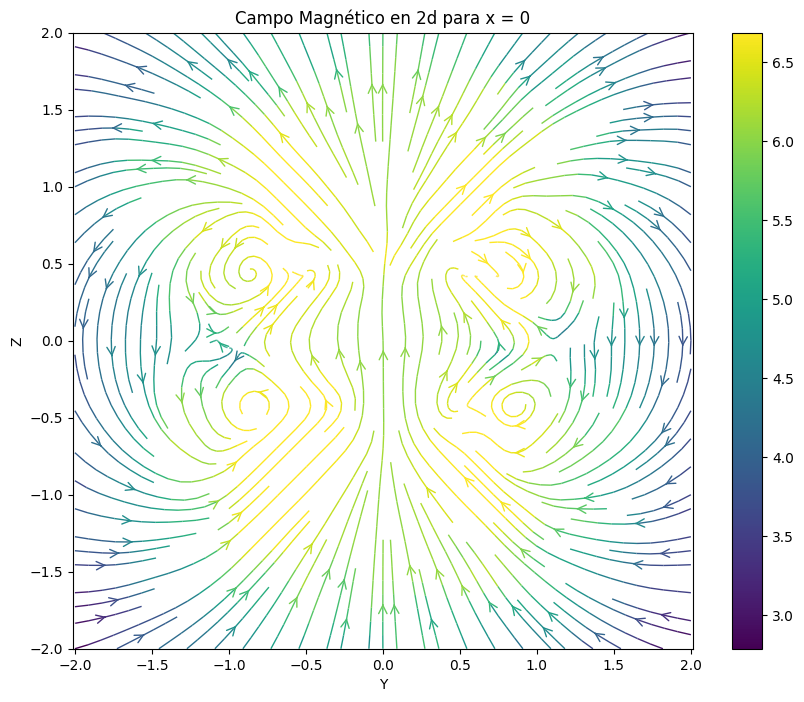

In [42]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

x_cut = 0

# Finding the index for the cut
cut_index = np.where(np.abs(xv - x_cut) < 1)

# Obtaining data to graph
y_slice_data = yv[cut_index]
z_slice_data = zv[cut_index]

By_slice_data = By[cut_index]
Bz_slice_data = Bz[cut_index]

# Initializing the grid
y_grid = np.linspace(-2, 2, 20)
z_grid = np.linspace(-2, 2, 20)
Y_grid, Z_grid = np.meshgrid(y_grid, z_grid)

# Interpolate the vector components
By_grid = griddata((y_slice_data, z_slice_data), By_slice_data, (Y_grid, Z_grid), method='linear')
Bz_grid = griddata((y_slice_data, z_slice_data), Bz_slice_data, (Y_grid, Z_grid), method='linear')

# Create 2D plot with streamplot
plt.figure(figsize=(10,8))
color = 2 * np.log(np.hypot(By_grid, Bz_grid))
plt.streamplot(y_grid, z_grid, By_grid, Bz_grid, color=color, linewidth=1, cmap='viridis',
          density=1.5, arrowstyle='->', arrowsize=1.5)
plt.title(f'Campo Magnético en 2d para x = {x_cut}')
plt.xlabel('Y')
plt.ylabel('Z')
plt.colorbar()
plt.axis('equal')
plt.show()